This notebook contains the project for Complex system simulation, Complex financial networks

In [23]:
# imports
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import sys
import os
import time
import datetime
import pickle
import argparse
import itertools
from typing import Dict, List, Any, Tuple
import doctest
import pandas as pd
import powerlaw
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import glob
import custom_functions_adj_saving_func as cm
import ast
from scipy import stats

In [24]:
def get_statistics_vary_threshold_v(pattern: str = './200_2000_*.csv'):
    def safe_literal_eval(s):
        try:
            return ast.literal_eval(s)
        except (ValueError, SyntaxError):
            return np.nan

    def calculate_average_list(column):
        return column.apply(safe_literal_eval).apply(lambda x: np.mean(x) if isinstance(x, list) and len(x) > 0 else np.nan)

    abs_diff_avg_per_run_per_threshold = {}

    for filepath in glob.glob(pattern):
        df = pd.read_csv(filepath)
        filename = os.path.basename(filepath).replace('.csv', '')
        parts = filename.split('_')
        threshold_v = float(parts[5])
        abs_diff_avg = calculate_average_list(df['Abs Difference of Bankrupt Agents Over Time'])
        if threshold_v not in abs_diff_avg_per_run_per_threshold:
            abs_diff_avg_per_run_per_threshold[threshold_v] = []
        abs_diff_avg_per_run_per_threshold[threshold_v].append(abs_diff_avg)

    return abs_diff_avg_per_run_per_threshold

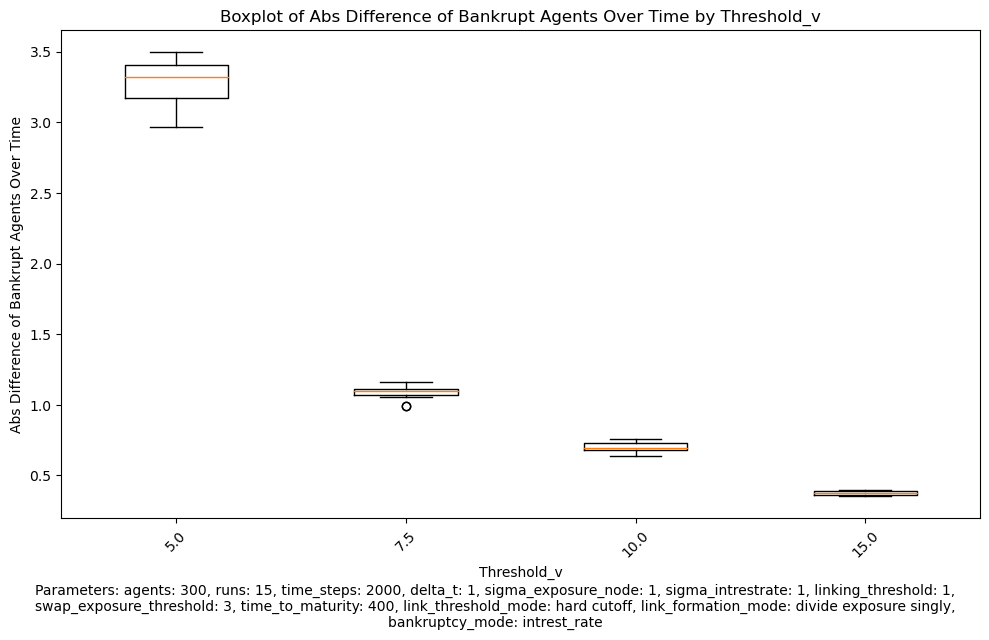

In [25]:
pattern = './300_2000_1_1_1_*_1_3_400_hard cutoff_divide exposure singly_intrest_rate_*.csv'
all_results = get_statistics_vary_threshold_v(pattern = pattern)

# The given dictionary data
data = all_results

# Remove NaN values and convert the data into NumPy arrays
thresholds = list(data.keys())
data_to_plot = []

for values in data.values():
    flattened_values = [x for sublist in values for x in sublist if not np.isnan(x)]
    data_to_plot.append(np.array(flattened_values))

# Sort the data by threshold values in ascending order
sorted_data = sorted(zip(thresholds, data_to_plot), key=lambda x: x[0])
thresholds, data_to_plot = zip(*sorted_data)

param_caption = { "agents": 300,
  "runs": 15,
  "time_steps": 2000,
  "delta_t": 1,
  "sigma_exposure_node": 1,
  "sigma_intrestrate": 1,
  "linking_threshold": 1,
  "swap_exposure_threshold": 3,
  "linking_threshold": 1,
  "time_to_maturity": 400,
  "link_threshold_mode": "hard cutoff",
  "link_formation_mode": 'divide exposure singly',
  "bankruptcy_mode": "intrest_rate",
}

# Convert the dictionary into a string without curly braces and double quotes
param_caption_str = ', '.join(f"{key}: {value}" for key, value in param_caption.items())

# Create the box plot
plt.figure(figsize=(10, 6))
plt.boxplot(data_to_plot, labels=thresholds)
plt.xlabel('Threshold_v')
plt.ylabel('Abs Difference of Bankrupt Agents Over Time')
plt.title('Boxplot of Abs Difference of Bankrupt Agents Over Time by Threshold_v')
plt.xticks(rotation=45)
plt.tight_layout()
plt.figtext(0.5, -0.05, f"Parameters: {param_caption_str}", wrap=True, horizontalalignment='center', fontsize=10)
plt.show()

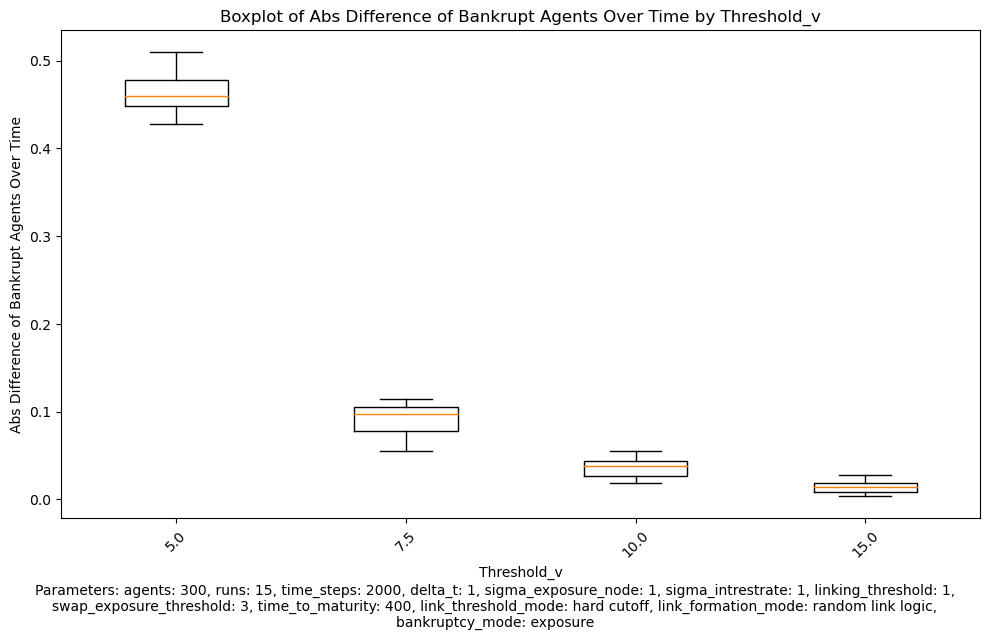

In [26]:
pattern = './300_2000_1_1_1_*_1_3_400_hard cutoff_random link logic_exposure_*.csv'
all_results = get_statistics_vary_threshold_v(pattern = pattern)

# The given dictionary data
data = all_results

# Remove NaN values and convert the data into NumPy arrays
thresholds = list(data.keys())
data_to_plot = []

for values in data.values():
    flattened_values = [x for sublist in values for x in sublist if not np.isnan(x)]
    data_to_plot.append(np.array(flattened_values))

# Sort the data by threshold values in ascending order
sorted_data = sorted(zip(thresholds, data_to_plot), key=lambda x: x[0])
thresholds, data_to_plot = zip(*sorted_data)

param_caption = { "agents": 300,
  "runs": 15,
  "time_steps": 2000,
  "delta_t": 1,
  "sigma_exposure_node": 1,
  "sigma_intrestrate": 1,
  "linking_threshold": 1,
  "swap_exposure_threshold": 3,
  "linking_threshold": 1,
  "time_to_maturity": 400,
  "link_threshold_mode": "hard cutoff",
  "link_formation_mode": 'random link logic',
  "bankruptcy_mode": "exposure",
}

# Convert the dictionary into a string without curly braces and double quotes
param_caption_str = ', '.join(f"{key}: {value}" for key, value in param_caption.items())

# Create the box plot
plt.figure(figsize=(10, 6))
plt.boxplot(data_to_plot, labels=thresholds)
plt.xlabel('Threshold_v')
plt.ylabel('Abs Difference of Bankrupt Agents Over Time')
plt.title('Boxplot of Abs Difference of Bankrupt Agents Over Time by Threshold_v')
plt.xticks(rotation=45)
plt.tight_layout()
plt.figtext(0.5, -0.05, f"Parameters: {param_caption_str}", wrap=True, horizontalalignment='center', fontsize=10)
plt.show()

In [19]:
def compare_group_means(*groups):
    """
    Compare means of multiple groups using ANOVA or Kruskal-Wallis test.
    Includes a conclusion based on the hypothesis test.
    """
    # Check for zero variance within each group
    if any(np.ptp(group) == 0 for group in groups):
        print("One or more groups have zero variance, performing non-parametric Kruskal-Wallis test.")
        kruskal_result = stats.kruskal(*groups)
        conclusion = "There is no significant difference between the groups." if kruskal_result.pvalue > 0.05 else "There is a significant difference between the groups."
        return f"Kruskal-Wallis Test Result:\nH-statistic: {kruskal_result.statistic}\nP-value: {kruskal_result.pvalue}\nConclusion: {conclusion}"

    # Create a DataFrame to hold all groups data
    group_labels = [f'group{i+1}' for i in range(len(groups))]
    data_values = []
    data_groups = []
    for i, group in enumerate(groups):
        data_values.extend(group)
        data_groups.extend([group_labels[i]] * len(group))
    
    df = pd.DataFrame({'value': data_values, 'group': data_groups})

    # Checking for normality and homogeneity of variances
    normality_p_values = [stats.shapiro(df[df['group'] == group]['value']).pvalue for group in group_labels]
    normal = all(p > 0.05 for p in normality_p_values)
    homogeneity_p_value = stats.levene(*groups).pvalue
    homogeneous = homogeneity_p_value > 0.05

    if normal and homogeneous:
        print("The data is normal and homogeneous, performing ANOVA.")
        # Perform ANOVA
        model = ols('value ~ C(group)', data=df).fit()
        anova_result = sm.stats.anova_lm(model, typ=2)
        conclusion = "There is no significant difference between the groups." if anova_result['PR(>F)'].iloc[0] > 0.05 else "There is a significant difference between the groups."
        return f"ANOVA Result:\n{anova_result}\nConclusion: {conclusion}"
    else:
        print("The data is not normal and/or not homogeneous, performing non-parametric Kruskal-Wallis test.")
        # Perform Kruskal-Wallis Test
        kruskal_result = stats.kruskal(*groups)
        conclusion = "There is no significant difference between the groups." if kruskal_result.pvalue > 0.05 else "There is a significant difference between the groups."
        return f"Kruskal-Wallis Test Result:\nH-statistic: {kruskal_result.statistic}\nP-value: {kruskal_result.pvalue}\nConclusion: {conclusion}"

In [27]:
def perform_pairwise_comparisons(data_to_plot1, data_to_plot2, thresholds):
    for i in range(min(len(data_to_plot1), len(data_to_plot2))):
        result = compare_group_means(data_to_plot1[i], data_to_plot2[i])
        print(f"Comparison for Threshold {thresholds[i]}: \n {result}\n")

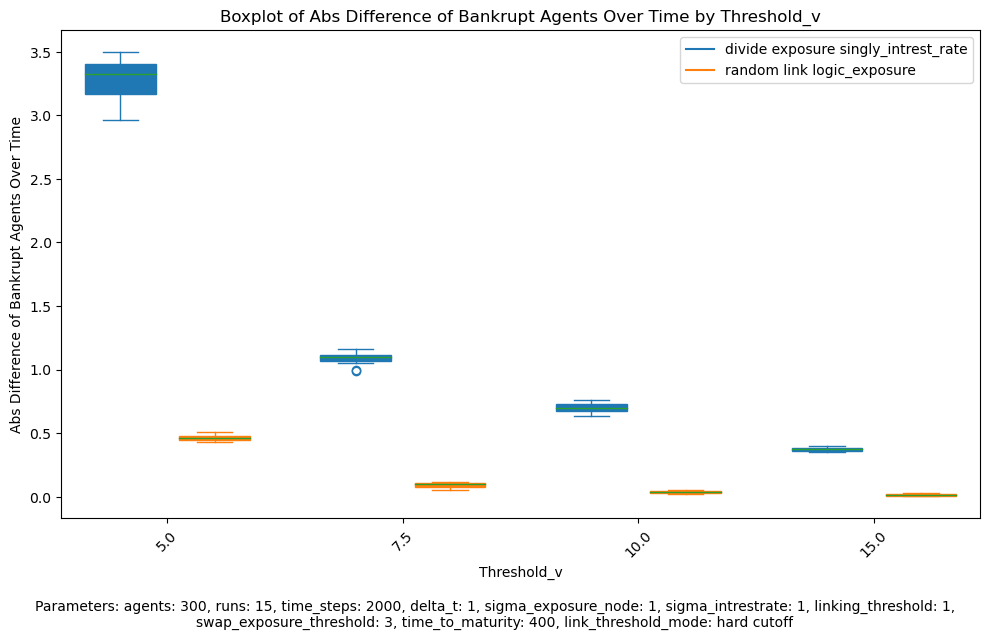

The data is not normal and/or not homogeneous, performing non-parametric Kruskal-Wallis test.
Comparison for Threshold 5.0: 
 Kruskal-Wallis Test Result:
H-statistic: 23.27272727272728
P-value: 1.405793518097843e-06
Conclusion: There is a significant difference between the groups.

The data is not normal and/or not homogeneous, performing non-parametric Kruskal-Wallis test.
Comparison for Threshold 7.5: 
 Kruskal-Wallis Test Result:
H-statistic: 21.774193548387103
P-value: 3.0669777654622633e-06
Conclusion: There is a significant difference between the groups.

The data is not normal and/or not homogeneous, performing non-parametric Kruskal-Wallis test.
Comparison for Threshold 10.0: 
 Kruskal-Wallis Test Result:
H-statistic: 21.788735529830817
P-value: 3.043819488945355e-06
Conclusion: There is a significant difference between the groups.

The data is not normal and/or not homogeneous, performing non-parametric Kruskal-Wallis test.
Comparison for Threshold 15.0: 
 Kruskal-Wallis Test 

In [28]:
# First dataset，our mode
pattern1 = './300_2000_1_1_1_*_1_3_400_hard cutoff_divide exposure singly_intrest_rate_*.csv'
all_results1 = get_statistics_vary_threshold_v(pattern=pattern1)
data1 = all_results1
thresholds1 = list(data1.keys())
data_to_plot1 = []
for values in data1.values():
    flattened_values = [x for sublist in values for x in sublist if not np.isnan(x)]
    data_to_plot1.append(np.array(flattened_values))
sorted_data1 = sorted(zip(thresholds1, data_to_plot1), key=lambda x: x[0])
thresholds1, data_to_plot1 = zip(*sorted_data1)

# Second dataset, paper mode
pattern2 = './300_2000_1_1_1_*_1_3_400_hard cutoff_random link logic_exposure_*.csv'
all_results2 = get_statistics_vary_threshold_v(pattern=pattern2)
data2 = all_results2
thresholds2 = list(data2.keys())
data_to_plot2 = []
for values in data2.values():
    flattened_values = [x for sublist in values for x in sublist if not np.isnan(x)]
    data_to_plot2.append(np.array(flattened_values))
# Sorting the data by threshold values in ascending order
sorted_data2 = sorted(zip(thresholds2, data_to_plot2), key=lambda x: x[0])
thresholds2, data_to_plot2 = zip(*sorted_data2)

param_caption = { "agents": 300,
  "runs": 15,
  "time_steps": 2000,
  "delta_t": 1,
  "sigma_exposure_node": 1,
  "sigma_intrestrate": 1,
  "linking_threshold": 1,
  "swap_exposure_threshold": 3,
  "linking_threshold": 1,
  "time_to_maturity": 400,
  "link_threshold_mode": "hard cutoff",
}

# Convert the dictionary into a string without curly braces and double quotes
param_caption_str = ', '.join(f"{key}: {value}" for key, value in param_caption.items())

# Creating the boxplot
plt.figure(figsize=(10, 6))

# Plotting the boxplot for the first dataset
bp1 = plt.boxplot(data_to_plot1, positions=np.array(range(len(data_to_plot1)))*2.0-0.4, widths=0.6, patch_artist=True, boxprops=dict(facecolor='C0', color='C0'), whiskerprops=dict(color='C0'), capprops=dict(color='C0'), medianprops=dict(color='C2'), flierprops=dict(markeredgecolor='C0'))

# Plotting the boxplot for the second dataset
bp2 = plt.boxplot(data_to_plot2, positions=np.array(range(len(data_to_plot2)))*2.0+0.4, widths=0.6, patch_artist=True, boxprops=dict(facecolor='C1', color='C1'), whiskerprops=dict(color='C1'), capprops=dict(color='C1'), medianprops=dict(color='C2'), flierprops=dict(markeredgecolor='C1'))

# Adding dummy lines for the legend
plt.plot([], c='C0', label='divide exposure singly_intrest_rate')
plt.plot([], c='C1', label='random link logic_exposure')

# Setting the axis labels and title
plt.xlabel('Threshold_v')
plt.ylabel('Abs Difference of Bankrupt Agents Over Time')
plt.title('Boxplot of Abs Difference of Bankrupt Agents Over Time by Threshold_v')

# Setting the tick labels on the x-axis
plt.xticks(np.arange(0, len(thresholds1) * 2, 2), thresholds1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.figtext(0.5, -0.05, f"Parameters: {param_caption_str}", wrap=True, horizontalalignment='center', fontsize=10)
plt.show()

plt.show()

perform_pairwise_comparisons(data_to_plot1, data_to_plot2, thresholds1)